# Tensorflow 101


## 0. Introduction to Jupyter Notebook

Jupyter notebook is often used by data scientists who work in Python. It is loosely based on Mathematica and combines code, text and visual output in one page.

## 0.1 Jupyter Notebook short cuts


Some relevant short cuts:
* ```SHIFT + ENTER``` executes 1 block of code called a cell
* Tab completion is omnipresent after the import of a package has been executed
* ```SHIFT + TAB``` gives you extra information on what parameters a function takes
* Repeating ```SHIFT + TAB``` multiple times gives you even more information

To get used to these short cuts try them out on the cell below.

In [2]:
print 'Hello world!'
print range(5)

Hello world!
[0, 1, 2, 3, 4]


## 1. Importing The Data


Let's start with importing and exploring the data we'll be using.

We will work with the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset for immage classification. The data consists of images of handwritten digits ranging from 0 to 9. Here mnist is a lightweight class which stores the training, validation, and testing sets as NumPy arrays:

- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


There are 55000 train images each consisting of 28x28 = 784 pixels
and 10 classes (the numbers 0 to 9) 

In [4]:
import numpy as np

print(np.shape(mnist.train.images))
print(np.shape(mnist.train.labels))

(55000, 784)
(55000, 10)


And we have 10000 test images

In [5]:
print(np.shape(mnist.test.images))
print(np.shape(mnist.test.labels))

(10000, 784)
(10000, 10)


---
## 1.1 Exploring The Data


Let's take a peek at the data to make sure it looks sensible. Each exemplar is an image of a handwritten digit from 0 through 9. We'll display some samples of the images that we just downloaded using matplotlib.

---

our labels are one hot encoded vectors of length 10

In [6]:
print(mnist.train.labels[0])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


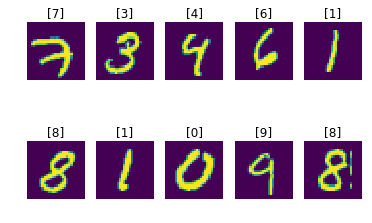

In [7]:
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline



for i, img in enumerate(mnist.train.images[0:10]):
    plt.subplot(2, 5, i+1)
    
    # the one hot encoded vectors have a '1' at the position of the class
    plt.title(np.nonzero(mnist.train.labels[i])[0])
    plt.axis('off')
    img = np.reshape(img,[28,28])

    plt.imshow(img)

In [8]:
num_labels = len(mnist.train.labels[0])

train_dataset, train_labels = mnist.train.images, mnist.train.labels
valid_dataset, valid_labels = mnist.validation.images, mnist.validation.labels
test_dataset, test_labels = mnist.test.images, mnist.test.labels
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (55000, 784), (55000, 10))
('Validation set', (5000, 784), (5000, 10))
('Test set', (10000, 784), (10000, 10))


In [9]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## 1.2 Benchmark Classifier

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.
We'll use a RandomForest classifier from sklearn as benchmark classifier.


In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
RFC = RandomForestClassifier(n_estimators=20,min_samples_split=10)

In [12]:
RFC.fit(train_dataset,train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [13]:
test_prediction = RFC.predict(test_dataset)
print 'test accuracy: ',accuracy(test_prediction,test_labels) , '%'

test accuracy:  88.84 %


That's already not too bad! Let's see if we can improve this with deep learning!

## 2. Tensorflow 

In [14]:
import tensorflow as tf



To do efficient numerical computing in Python, we typically use libraries like NumPy that do expensive operations such as matrix multiplication outside Python, using highly efficient code implemented in another language. Unfortunately, there can still be a lot of overhead from switching back to Python every operation. This overhead is especially bad if you want to run computations on GPUs or in a distributed manner, where there can be a high cost to transferring data.

TensorFlow also does its heavy lifting outside Python, but it takes things a step further to avoid this overhead. Instead of running a single expensive operation independently from Python, TensorFlow lets us describe a graph of interacting operations that run entirely outside Python. The role of the Python code is therefore to build this external computation graph, and to dictate which parts of the computation graph should be run. 

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...



### 2.1 Implementing Multinomial Logistic Regression in TensorFlow

#### 2.1.1 Gradient Descent 

First we'll build a multinomial logistic regression model in tensorflow. Here for each training step all the training examples will be presented to the model and the loss will be calculated over all these training samples. The weights will then be updated according to this loss.

In [15]:
# With gradient descent training, even this much data is prohibitive.

# square images of 28 pixels width and 28 pixels heigt --> 28*28 =784 pixels
image_size = 28 

# 10 different output classes
num_labels = train_labels.shape[1] 

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset)
    tf_train_labels = tf.constant(train_labels)
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [16]:
# will be really slow, so you can decrease num_steps

num_steps = 701


with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
                predictions, train_labels))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 14.785463
Training accuracy: 7.1%
Validation accuracy: 6.9%
Test accuracy: 7.0%
Test accuracy: 8.2%
Test accuracy: 10.1%
Test accuracy: 12.4%
Test accuracy: 14.8%
Test accuracy: 17.3%
Test accuracy: 19.7%
Test accuracy: 22.2%
Test accuracy: 24.5%
Test accuracy: 26.9%
Test accuracy: 28.9%
Test accuracy: 31.0%
Test accuracy: 33.0%
Test accuracy: 34.8%
Test accuracy: 36.8%
Test accuracy: 38.7%
Test accuracy: 40.4%
Test accuracy: 42.0%
Test accuracy: 43.5%
Test accuracy: 45.0%
Test accuracy: 46.3%
Test accuracy: 47.6%
Test accuracy: 48.9%
Test accuracy: 50.0%
Test accuracy: 51.0%
Test accuracy: 52.2%
Test accuracy: 53.2%
Test accuracy: 54.3%
Test accuracy: 55.1%
Test accuracy: 55.9%
Test accuracy: 56.8%
Test accuracy: 57.6%
Test accuracy: 58.2%
Test accuracy: 58.9%
Test accuracy: 59.6%
Test accuracy: 60.2%
Test accuracy: 60.8%
Test accuracy: 61.3%
Test accuracy: 61.9%
Test accuracy: 62.4%
Test accuracy: 62.9%
Test accuracy: 63.5%
Test accuracy: 63.9%
Test accura

KeyboardInterrupt: 

#### 2.1.2 Stochastic Gradient Descent (SGD)

As you have experienced, training the model using the full dataset for each update step took a long time... So let's speed things up! We'll now switch to stochastic gradient descent training instead, which is much faster. Now, instead of taking the full training set to compute the error, we only present a small subset of the training data (a.k.a a training batch) during each training step. The weights are then updated according to the error made on this subset of training samples. Although this might seem strange at first sight, if we randomize the batches and use enough iterations, on average the model will have seen all the training examples! Training will go much faster, as you will notice in a moment!  

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [17]:
batch_size = 128

# square images of 28 pixels width and 28 pixels heigt --> 28*28 =784 pixels
image_size = 28 

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [18]:
# SGD needs more iterations than Gradient Descent, however each iteration will go much faster!
num_steps = 3001  

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)) # accuracy of the used training batch
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 12.326206
Minibatch accuracy: 4.7%
Validation accuracy: 10.6%
Minibatch loss at step 500: 0.836916
Minibatch accuracy: 80.5%
Validation accuracy: 86.2%
Minibatch loss at step 1000: 0.276452
Minibatch accuracy: 91.4%
Validation accuracy: 88.6%
Minibatch loss at step 1500: 0.642790
Minibatch accuracy: 80.5%
Validation accuracy: 89.1%
Minibatch loss at step 2000: 0.468029
Minibatch accuracy: 86.7%
Validation accuracy: 89.8%
Minibatch loss at step 2500: 0.275213
Minibatch accuracy: 89.8%
Validation accuracy: 90.1%
Minibatch loss at step 3000: 0.076048
Minibatch accuracy: 96.9%
Validation accuracy: 90.0%
Test accuracy: 89.3%


That was fast! 

---
Problem 1
-------

Now it's up to you to turn this logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [21]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # new hidden layer
    hidden_nodes = 1024
    hidden_weights = tf.Variable( tf.truncated_normal([image_size * image_size, hidden_nodes]) )
    hidden_biases = tf.Variable( tf.zeros([hidden_nodes]))
    hidden_layer = tf.nn.relu( tf.matmul( tf_train_dataset, hidden_weights) + hidden_biases)
  
    # Variables.
    weights = tf.Variable( tf.truncated_normal([hidden_nodes, num_labels])) 
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(hidden_layer, weights) + biases
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( labels = tf_train_labels, logits = logits) )
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(  tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax( tf.matmul(valid_relu, weights) + biases) 

    test_relu = tf.nn.relu( tf.matmul( tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights) + biases)

In [22]:
num_steps = 4001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 312.882629
Minibatch accuracy: 8.6%
Validation accuracy: 22.7%
Minibatch loss at step 500: 0.567973
Minibatch accuracy: 93.8%
Validation accuracy: 92.6%
Minibatch loss at step 1000: 0.062707
Minibatch accuracy: 98.4%
Validation accuracy: 93.6%
Minibatch loss at step 1500: 0.137629
Minibatch accuracy: 96.1%
Validation accuracy: 94.1%
Minibatch loss at step 2000: 0.015088
Minibatch accuracy: 100.0%
Validation accuracy: 94.1%
Minibatch loss at step 2500: 0.021324
Minibatch accuracy: 99.2%
Validation accuracy: 94.4%
Minibatch loss at step 3000: 0.004934
Minibatch accuracy: 100.0%
Validation accuracy: 94.4%
Minibatch loss at step 3500: 0.003097
Minibatch accuracy: 100.0%
Validation accuracy: 94.4%
Minibatch loss at step 4000: 0.001059
Minibatch accuracy: 100.0%
Validation accuracy: 94.6%
Test accuracy: 94.4%


### 2.2 Regularization


The goal of this assignment is to explore regularization techniques.

---
Problem 2
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [24]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
    # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
              beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [25]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 538.151123
Minibatch accuracy: 14.1%
Validation accuracy: 18.0%
Minibatch loss at step 500: 192.835709
Minibatch accuracy: 95.3%
Validation accuracy: 93.2%
Minibatch loss at step 1000: 116.794327
Minibatch accuracy: 99.2%
Validation accuracy: 94.3%
Minibatch loss at step 1500: 70.926697
Minibatch accuracy: 96.9%
Validation accuracy: 95.0%
Minibatch loss at step 2000: 43.036919
Minibatch accuracy: 99.2%
Validation accuracy: 96.1%
Minibatch loss at step 2500: 26.132961
Minibatch accuracy: 98.4%
Validation accuracy: 96.8%
Minibatch loss at step 3000: 15.855141
Minibatch accuracy: 100.0%
Validation accuracy: 97.0%
Test accuracy: 96.5%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [27]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels= tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [28]:
num_steps = 4001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 477.055359
Minibatch accuracy: 8.6%
Validation accuracy: 26.7%
Minibatch loss at step 500: 1.381874
Minibatch accuracy: 84.4%
Validation accuracy: 91.9%
Minibatch loss at step 1000: 0.407621
Minibatch accuracy: 91.4%
Validation accuracy: 93.0%
Minibatch loss at step 1500: 0.705509
Minibatch accuracy: 81.2%
Validation accuracy: 93.5%
Minibatch loss at step 2000: 0.654068
Minibatch accuracy: 89.1%
Validation accuracy: 94.0%
Minibatch loss at step 2500: 0.456166
Minibatch accuracy: 88.3%
Validation accuracy: 94.5%
Minibatch loss at step 3000: 0.098233
Minibatch accuracy: 97.7%
Validation accuracy: 94.8%
Minibatch loss at step 3500: 0.582637
Minibatch accuracy: 85.9%
Validation accuracy: 95.2%
Minibatch loss at step 4000: 0.291427
Minibatch accuracy: 93.8%
Validation accuracy: 95.2%
Test accuracy: 94.5%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model!
One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [32]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(
        tf.truncated_normal(
            [image_size * image_size, num_hidden_nodes1],
            stddev=np.sqrt(2.0 / (image_size * image_size)))
        )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= tf_train_labels))
  
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [31]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 2.330882
Minibatch accuracy: 13.3%
Validation accuracy: 34.3%
Minibatch loss at step 500: 0.150851
Minibatch accuracy: 96.1%
Validation accuracy: 96.4%
Minibatch loss at step 1000: 0.025660
Minibatch accuracy: 99.2%
Validation accuracy: 97.7%
Minibatch loss at step 1500: 0.051042
Minibatch accuracy: 98.4%
Validation accuracy: 96.8%
Minibatch loss at step 2000: 0.019785
Minibatch accuracy: 99.2%
Validation accuracy: 98.1%
Minibatch loss at step 2500: 0.014415
Minibatch accuracy: 99.2%
Validation accuracy: 97.8%
Minibatch loss at step 3000: 0.006614
Minibatch accuracy: 100.0%
Validation accuracy: 97.3%
Minibatch loss at step 3500: 0.004093
Minibatch accuracy: 100.0%
Validation accuracy: 98.2%
Minibatch loss at step 4000: 0.032022
Minibatch accuracy: 99.2%
Validation accuracy: 98.4%
Minibatch loss at step 4500: 0.001708
Minibatch accuracy: 100.0%
Validation accuracy: 98.4%
Minib

KeyboardInterrupt: 

## 3. Convolutional Neural Networks


Previously we trained fully connected networks to classify the mnist numbers!
However, neural networks really start to shine on image data when we use convolutions. This will be introduced in this part!

### 3.1 Reshape Data

First we'll need to reformat our images into a TensorFlow-friendly shape for convolutions!
- convolutions need the image data formatted as a cube: width by height by #channels (RGB, SVH,...)


In [33]:
image_size = 28
num_labels = 10
num_channels = 1 # we only work with grayscale


def reformat(dataset):
    
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (55000, 28, 28, 1), (55000, 10))
('Validation set', (5000, 28, 28, 1), (5000, 10))
('Test set', (10000, 28, 28, 1), (10000, 10))


### 3.2 First ConvNet

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [34]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
          [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [35]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.364890
Minibatch accuracy: 6.2%
Validation accuracy: 11.3%
Minibatch loss at step 50: 2.066435
Minibatch accuracy: 12.5%
Validation accuracy: 48.1%
Minibatch loss at step 100: 0.909678
Minibatch accuracy: 62.5%
Validation accuracy: 75.2%
Minibatch loss at step 150: 0.556946
Minibatch accuracy: 75.0%
Validation accuracy: 80.3%
Minibatch loss at step 200: 1.266023
Minibatch accuracy: 75.0%
Validation accuracy: 76.2%
Minibatch loss at step 250: 0.368713
Minibatch accuracy: 81.2%
Validation accuracy: 85.3%
Minibatch loss at step 300: 0.525872
Minibatch accuracy: 81.2%
Validation accuracy: 84.7%
Minibatch loss at step 350: 0.079405
Minibatch accuracy: 100.0%
Validation accuracy: 90.2%
Minibatch loss at step 400: 0.325029
Minibatch accuracy: 87.5%
Validation accuracy: 90.5%
Minibatch loss at step 450: 0.190409
Minibatch accuracy: 93.8%
Validation accuracy: 88.3%
Minibatch loss at step 500: 0.346621
Minibatch accuracy: 87.5%
Validation accuracy: 89.2%
M

---
Problem 5
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [37]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
          [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        bias1 = tf.nn.relu(conv1 + layer1_biases)
        pool1 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        bias2 = tf.nn.relu(conv2 + layer2_biases)
        pool2 = tf.nn.max_pool(bias2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [38]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 3.404713
Minibatch accuracy: 0.0%
Validation accuracy: 9.6%
Minibatch loss at step 50: 2.088610
Minibatch accuracy: 31.2%
Validation accuracy: 26.5%
Minibatch loss at step 100: 1.148937
Minibatch accuracy: 68.8%
Validation accuracy: 65.4%
Minibatch loss at step 150: 0.685320
Minibatch accuracy: 75.0%
Validation accuracy: 73.2%
Minibatch loss at step 200: 1.181075
Minibatch accuracy: 62.5%
Validation accuracy: 75.6%
Minibatch loss at step 250: 0.295858
Minibatch accuracy: 87.5%
Validation accuracy: 88.2%
Minibatch loss at step 300: 0.433954
Minibatch accuracy: 87.5%
Validation accuracy: 89.8%
Minibatch loss at step 350: 0.048523
Minibatch accuracy: 100.0%
Validation accuracy: 92.4%
Minibatch loss at step 400: 0.176233
Minibatch accuracy: 93.8%
Validation accuracy: 91.9%
Minibatch loss at step 450: 0.075218
Minibatch accuracy: 100.0%
Validation accuracy: 90.9%
Minibatch loss at

---
Problem 6
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---